Summary of my results:

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 3.355085 | 4.272877 | 0.382089 | 0.291899
\+ teacher forcing | 3.154585 |	4.022432 | 0.407792 | 0.310715
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Translation with an RNN

This notebook is modified from [this one](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb) created by Sylvain Gugger.

Today we will be tackling the task of translation. We will be translating from French to English, and to keep our task a manageable size, we will limit ourselves to translating questions.

This task is an example of sequence to sequence (seq2seq). Seq2seq can be more challenging than classification, since the output is of variable length (and typically different from the length of the input.

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

Translation is much tougher in straight PyTorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from fastai.text import *

## Download and preprocess our data

We will start by reducing the original dataset to questions. You only need to execute this once, uncomment to run. The dataset can be downloaded [here](https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz).

In [2]:
path = Config().data_path()

In [3]:
path

PosixPath('/root/.fastai/data')

In [5]:
! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}

--2020-06-15 18:57:36--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.133.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.133.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/root/.fastai/data/giga-fren.tgz’

giga-fren.tgz       100%[===================>]   2.42G  26.6MB/s    in 1m 44s  

2020-06-15 18:59:21 (23.8 MB/s) - ‘/root/.fastai/data/giga-fren.tgz’ saved [2598183296/2598183296]



In [6]:
! tar xf {path}/giga-fren.tgz -C {path} 

In [7]:
path = Config().data_path()/'giga-fren'
path.ls()

[PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.fr')]

In [6]:
# with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')

In [7]:
# with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')

We will use regex to pick out questions by finding the strings in the English dataset that start with "Wh" and end with a question mark.  You only need to run these lines once:

In [8]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
en_fname = path/'giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren.release2.fixed.fr'

In [9]:
lines = ((re_eq.search(eq), re_fq.search(fq)) 
        for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [10]:
qs = [(q1,q2) for q1,q2 in qs]
df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

In [11]:
path.ls()

[PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/root/.fastai/data/giga-fren/questions_easy.csv')]

## Load our data into a DataBunch

Our questions look like this now:

In [12]:
df = pd.read_csv(path/'questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


To make it simple, we lowercase everything.

In [13]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['fr'] = df['fr'].apply(lambda x:x.lower())

The first thing is that we will need to collate inputs and targets in a batch: they have different lengths so we need to add padding to make the sequence length the same;

In [14]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

Then we create a special `DataBunch` that uses this collate function.

In [8]:
doc(Dataset)

In [9]:
doc(DataLoader)

In [6]:
doc(DataBunch)

In [15]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [ ]:
SortishSampler??

And a subclass of `TextList` that will use this `DataBunch` class in the call `.databunch` and will use `TextList` to label (since our targets are other texts).

In [16]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Thats all we need to use the data block API!

In [17]:
src = Seq2SeqTextList.from_df(df, path = path, cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

In [18]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

28.0

In [19]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

23.0

We remove the items where one of the target is more than 30 tokens long.

In [20]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [21]:
len(src.train) + len(src.valid)

48350

In [22]:
data = src.databunch()

In [23]:
data.save()

In [24]:
data

Seq2SeqDataBunch;

Train: LabelList (38704 items)
x: Seq2SeqTextList
xxbos qu’est - ce que la lumière ?,xxbos où sommes - nous ?,xxbos d'où venons - nous ?,xxbos que ferions - nous sans elle ?,xxbos quel est le groupe autochtone principal sur l’île de vancouver ?
y: TextList
xxbos what is light ?,xxbos who are we ?,xxbos where did we come from ?,xxbos what would we do without it ?,xxbos what is the major aboriginal group on vancouver island ?
Path: /root/.fastai/data/giga-fren;

Valid: LabelList (9646 items)
x: Seq2SeqTextList
xxbos quels pourraient être les effets sur l’instrument de xxunk et sur l’aide humanitaire qui ne sont pas co - xxunk ?,xxbos quand la source primaire a - t - elle été créée ?,xxbos pourquoi tant de soldats ont - ils fait xxunk de ne pas voir ce qui s'est passé le 4 et le 16 mars ?,xxbos quels sont les taux d'impôt sur le revenu au canada pour 2007 ?,xxbos pourquoi le programme devrait - il intéresser les employeurs et les fournisseurs de services ?
y: TextList
x

In [25]:
path

PosixPath('/root/.fastai/data/giga-fren')

In [26]:
data = load_data(path)

In [27]:
data.show_batch()

text,target
"xxbos quels services offrez - vous aux résidents , par l'entremise de votre propre organisation , par l'entremise de liens / partenariats avec des organismes communautaires ou les deux ?",xxbos which of the following services do you offer to residents either through your own organization or through linkages and / or partnerships with community agencies or both ?
"xxbos quelles initiatives ont été prises , conformément aux recommandations précédentes du comité , pour sensibiliser tant les hommes que les femmes à la contraception et aux méthodes xxunk ?","xxbos what steps have been taken , in line with the committee ’s previous recommendations , to raise awareness about contraception and xxunk methods among both men and women ?"
xxbos qu’en est - il d’un leader qui ne possède que deux de ces caractéristiques ou de celui qui ne manifeste que de temps en temps certains comportements xxunk ?,xxbos what if a leader xxunk only two of the factors ?
"xxbos quels mécanismes d'évaluation , de surveillance ou de responsabilisation sont en place pour l'étude de cas , tant dans le cadre de l'initiative qu'à l'intérieur de votre organisation ?","xxbos what evaluation , monitoring or other accountability mechanisms are in place for this work , within the initiative and within your organization ?"
"xxbos quelles sont les hypothèses , selon la définition actuelle du développement , do nt les pays en développement sont censés s'inspirer pour réformer leurs systèmes de politique sociale ?",xxbos what are the assumptions in the current understanding of development that developing countries are expected to accommodate in reforming their social - policy systems ?


## Create our Model

### Pretrained embeddings

You will need to download the word embeddings (crawl vectors) from the fastText docs. FastText has [pre-trained word vectors](https://fasttext.cc/docs/en/crawl-vectors.html) for 157 languages, trained on Common Crawl and Wikipedia. These models were trained using CBOW.

If you need a refresher on word embeddings, you can check out my gentle intro in [this word embedding workshop](https://www.youtube.com/watch?v=25nC0n9ERq4&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=10&t=0s) with accompanying [github repo](https://github.com/fastai/word-embeddings-workshop). 

More reading on CBOW (Continuous Bag of Words vs. Skip-grams):

- [fastText tutorial](https://fasttext.cc/docs/en/unsupervised-tutorial.html#advanced-readers-skipgram-versus-cbow)
- [StackOverflow](https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words)

To install fastText:
```
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .
```

In [33]:
import fasttext as ft

The lines to download the word vectors only need to be run once:

In [29]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

--2020-06-15 19:29:52--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘/root/.fastai/data/giga-fren/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  10.4MB/s    in 7m 25s  

2020-06-15 19:37:18 (9.65 MB/s) - ‘/root/.fastai/data/giga-fren/cc.en.300.bin.gz’ saved [4503593528/4503593528]

--2020-06-15 19:37:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [31]:
! gunzip {path}/cc.en.300.bin.gz
! gunzip {path}/cc.fr.300.bin.gz

In [34]:
fr_vecs = ft.load_model(str((path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

We create an embedding module with the pretrained vectors and random data for the missing parts.

In [35]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [36]:
emb_enc = create_emb(fr_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [37]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([11336, 300]), torch.Size([8144, 300]))

In [38]:
model_path = Config().model_path()

In [40]:
torch.save(emb_enc, model_path/'fr_emb.pth')
torch.save(emb_dec, model_path/'en_emb.pth')

In [41]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

## Our Model

Review Question: What are the two types of numbers in deep learning?

### Encoders & Decoders

The model in itself consists in an encoder and a decoder

![Seq2seq model](images/seq2seq.png)

<center><i>Diagram from Smerity's <a href="https://smerity.com/articles/2016/google_nmt_arch.html">Peeking into the neural network architecture used for Google's Neural Machine Translation</a></i></center>

The encoder is a recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state.  A **hidden state** is the activations that come out of an RNN.

That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 30 iterations to make sure it's not an infinite loop at the beginning of training). 

We will use a GRU for our encoder and a separate GRU for our decoder. Other options are to use LSTMs or QRNNs (see here).  GRUs, LSTMs, and QRNNs all solve the problem of how RNNs can lack long-term memory.

Links:
- [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [fast.ai implementation of seq2seq with QRNNs](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb)

In [42]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [43]:
xb,yb = next(iter(data.valid_dl))

In [44]:
xb.shape

torch.Size([64, 30])

In [45]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [46]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(11336, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(8144, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=8144, bias=True)
)

In [47]:
len(xb[0])

30

In [48]:
h = rnn.encoder(64, xb.cpu())

In [49]:
h.size()

torch.Size([2, 64, 300])

The loss pads output and target so that they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy.

In [50]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

## Train our model

In [51]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


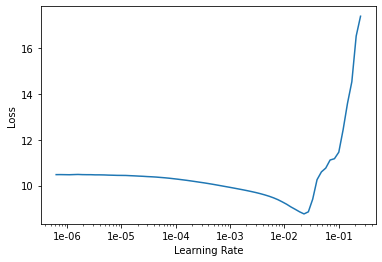

In [53]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,time
0,5.831800,5.377667,02:09
1,5.036271,4.308023,02:07
2,4.614872,4.543962,02:07
3,3.982590,4.585490,01:55


Let's free up some RAM

In [55]:
del fr_vecs
del en_vecs

As loss is not very interpretable, let's also look at the accuracy.  Again, we will add padding so that the output and target are of the same length.

In [61]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

### Bleu metric (see dedicated notebook)

In translation, the metric usually used is BLEU.

A great post by Rachael Tatman: [Evaluating Text Output in NLP: BLEU at your own risk](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)

In [56]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [57]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [58]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [59]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training with metrics

In [62]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

In [63]:
learn.lr_find()

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


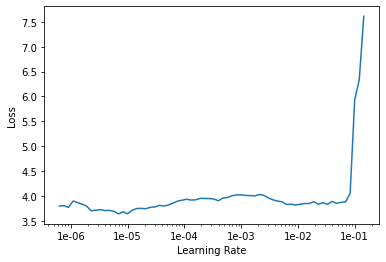

In [64]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.116266,4.349905,0.376701,0.286290,02:26
1,4.341300,5.166250,0.291891,0.233687,02:32


In [ ]:
learn.fit_one_cycle(4, 1e-3)

So how good is our model? Let's see a few predictions.

In [68]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [88]:
inputs, targets, outputs = get_predictions(learn)

In [89]:
inputs[700], targets[700], outputs[700]

(Text xxbos quels sont les résultats prévus à court et à long termes de xxunk , et dans quelle mesure ont - ils été obtenus ?,
 Text xxbos what are the short and long - term expected outcomes of the ali and to what extent have they been achieved ?,
 Text xxbos what were the results , the , , , , , , and and and and and)

In [90]:
inputs[701], targets[701], outputs[701]

(Text xxbos de quel(s ) xxunk ) a - t - on besoin pour xxunk les profits réels de la compagnie pour l'année qui vient ?,
 Text xxbos which of the following additional information is necessary to estimate the company 's actual profit for the coming year ?,
 Text xxbos what is the the to to to the the ( ( ) ))

In [91]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos de quelles façons l'expérience et les capacités particulières des agences d'exécution contribuent - elles au projet ?,
 Text xxbos what experience and specific capacities do the implementing organizations bring to the project ?,
 Text xxbos what are the key and and and and and and of of of of of of ?)

In [92]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos qu'est - ce que la maladie de xxunk - xxunk ( mcj ) ?,
 Text xxbos what is xxunk - xxunk disease ( cjd ) ?,
 Text xxbos what is the xxunk ( ( ) ))

It's usually beginning well, but falls into repeated words at the end of the question.

## Teacher forcing

One way to help training is to help the decoder by feeding it the real targets instead of its predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do that all the time at the beginning, then progressively reduce the amount of teacher forcing.

In [83]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

We will add the following code to our `forward` method:

```
    if (targ is not None) and (random.random()<self.pr_force):
        if i>=targ.shape[1]: break
        dec_inp = targ[:,i]
```
Additionally, `forward` will take an additional argument of `target`.

In [88]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [90]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

In [91]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 30)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
               callback_fns=partial(TeacherForcing, end_epoch=3))

In [74]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


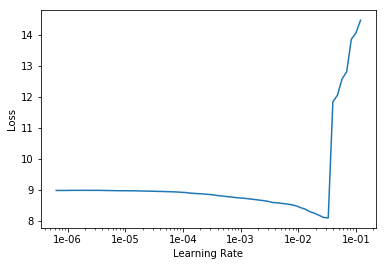

In [75]:
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(6, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.305473,5.401867,0.195743,0.094855,01:25
1,2.663129,4.858545,0.372653,0.335771,01:13
2,3.337267,4.305145,0.386822,0.319585,01:07
3,4.280678,4.937834,0.314167,0.240478,01:01
4,3.461964,4.086816,0.401147,0.304925,01:06
5,3.154585,4.022432,0.407792,0.310715,01:07


In [77]:
inputs, targets, outputs = get_predictions(learn)

In [78]:
inputs[700],targets[700],outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos who has the xxunk and xxunk and xxunk xxunk ?)

In [79]:
inputs[2513], targets[2513], outputs[2513]

(Text xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?,
 Text xxbos what two trends negatively affected the province ’s salmon fishery ?,
 Text xxbos what are the main reasons for the xxunk of the xxunk ?)

In [80]:
inputs[4000], targets[4000], outputs[4000]

(Text xxbos où les aires marines nationales de conservation du canada seront - elles situées ?,
 Text xxbos where will national marine conservation areas of canada be located ?,
 Text xxbos where are the canadian regulations located in the canadian ?)